In [128]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import torch
import malt
from malt.agents.player import SequentialModelBasedPlayer, SequentialRandomPlayer

model = malt.models.supervised_model.SimpleSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=128
    ),
    regressor=malt.models.regressor.NeuralNetworkRegressor(
        in_features=128, out_features=1
    ),
    likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
)

if torch.cuda.is_available():
    model.cuda()

marginal_likelihood = malt.models.marginal_likelihood.SimpleMarginalLogLikelihood(
    model.likelihood, model
)

# data = malt.data.collections.linear_alkanes(10)
# data = malt.data.collections.esol()
# data = data.shuffle()

results = []
for _ in tqdm(range(10)):
    
    player = SequentialModelBasedPlayer(
        model = model,
        marginal_likelihood=marginal_likelihood,
        policy=malt.policy.Greedy(acquisition_size=384),
        trainer=malt.trainer.get_default_trainer(),
        merchant=malt.agents.merchant.DatasetMerchant(data),
        assayer=malt.agents.assayer.DatasetAssayer(data),
    )

# rand_player = SequentialRandomPlayer(
#     merchant=malt.agents.merchant.DatasetMerchant(data),
#     assayer=malt.agents.assayer.DatasetAssayer(data),
#     seed=np.random.randint(1, 1e8)
# )

    while True:
        if player.step() is None or len(player.portfolio) > 800:
            break

    _, y = player.portfolio.batch()
    results.append(
        pd.DataFrame(y.cpu()).cummax().reset_index()
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


In [126]:
# _, y = player.portfolio.batch()

# pd.DataFrame(y.cpu()).cummax().plot()

In [116]:
# df = pd.concat(results)
# df.columns = ['index', 'score']
# df = df.reset_index(drop=True)

# rand_df = pd.concat(random_results)
# rand_df.columns = ['index', 'score']
# rand_df = rand_df.reset_index(drop=True)

<AxesSubplot:xlabel='index', ylabel='score'>

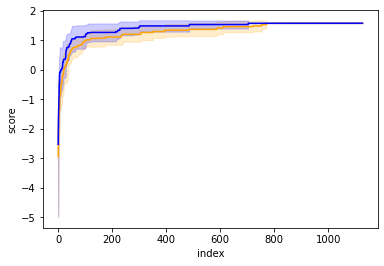

In [130]:
import seaborn as sns

sns.lineplot(data=rand_df, x='index', y='score', color='orange', ci='sd')
sns.lineplot(data=df, x='index', y='score', color='blue', ci='sd')